In [ ]:
# Cell 1: Project Environment Setup & Directory Initialization
# Purpose: Mounts Google Drive and creates the physical folder structure for all 4 team modules.
# Outcome: You will see "Created/Verified" messages for each folder.

import os
from google.colab import drive

# 1. Mount Google Drive (It will ask for permission)
drive.mount('/content/drive')

# 2. Define your Project Root (Change 'AI_Project_2026' if you want)
PROJECT_ROOT = "/content/drive/My Drive/AI_Project_2026"

# 3. Define the Directory Structure
folders = [
    f"{PROJECT_ROOT}/data",
    f"{PROJECT_ROOT}/age_analysis_engine/notebooks",
    f"{PROJECT_ROOT}/category_classifier",
    f"{PROJECT_ROOT}/impact_analysis",
    f"{PROJECT_ROOT}/clickbait_detector"
]

# 4. Create Folders
for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"✅ Created/Verified: {folder}")

# 5. Create the Shared 'data_loader.py'
data_loader_code = """
import pandas as pd

def load_dataset(columns=None):
    # This is a placeholder. Later we will point this to the real .parquet file
    print(f"Loading columns: {columns}...")
    return pd.DataFrame()
"""

with open(f"{PROJECT_ROOT}/data_loader.py", "w") as f:
    f.write(data_loader_code)

print("\n🚀 Project Structure Initialized Successfully!")

Mounted at /content/drive
✅ Created/Verified: /content/drive/My Drive/AI_Project_2026/data
✅ Created/Verified: /content/drive/My Drive/AI_Project_2026/age_analysis_engine/notebooks
✅ Created/Verified: /content/drive/My Drive/AI_Project_2026/category_classifier
✅ Created/Verified: /content/drive/My Drive/AI_Project_2026/impact_analysis
✅ Created/Verified: /content/drive/My Drive/AI_Project_2026/clickbait_detector

🚀 Project Structure Initialized Successfully!


In [ ]:
# Cell 2: Create Configuration Module (config.py)
# Purpose: Writes the 'config.py' file into your age_analysis_engine folder.
#          This file defines the strict rules, age brackets, and keyword categories our model will use.
# Note: We use '%%writefile' magic command to save this text directly to a .py file on your Drive.

output_path = "/content/drive/My Drive/AI_Project_2026/age_analysis_engine/config.py"

config_code = """
# CONFIGURATION FOR AGE ANALYSIS ENGINE
# This file defines the shared constants for the Age Analysis Module.

# 1. Output Classes (The Labels)
# We map internal IDs to human-readable labels.
AGE_LABELS = {
    0: "General Audience (G)",       # Safe for everyone
    1: "Teen / Guidance (13+)",      # Mild guidance suggested
    2: "Mature (18+)"                # Restricted audience
}

# 2. Thresholds
# How many "bad words" trigger a label? (These are initial heuristics to be tuned later)
THRESHOLDS = {
    "TEEN_MIN_COUNT": 1,    # Even 1 instance of mild profanity triggers 'Teen'
    "MATURE_MIN_COUNT": 1   # Even 1 instance of severe content triggers 'Mature'
}

# 3. Keyword Categories (The Evidence)
# We group keywords so we can give 'Justifications' (e.g. "Contains Profanity" instead of listing the F-word)
# NOTE: This is a starter list. We will expand this or replace it with a Model later.
SENSITIVE_TERMS = {
    "mild_profanity": ["damn", "hell", "crap", "stupid", "idiot"],
    "strong_profanity": ["f***", "s***", "bitch", "bastard"], # (Self-censored for code, usually explicit in production)
    "violence": ["kill", "murder", "blood", "shoot", "stab", "dead"],
    "substance": ["drug", "alcohol", "beer", "weed", "cocaine", "heroin"],
    "sexual": ["nude", "sex", "naked", "porn", "strip"]
}
"""

# Write the file to Google Drive
with open(output_path, "w") as f:
    f.write(config_code)

print(f"✅ Configuration file created at: {output_path}")
print("   - Defined 3 Age Brackets")
print("   - Defined 5 Sensitive Categories")

✅ Configuration file created at: /content/drive/My Drive/AI_Project_2026/age_analysis_engine/config.py
   - Defined 3 Age Brackets
   - Defined 5 Sensitive Categories


In [ ]:
# Cell 3: Generate Mock Data (Unit Test)
# Purpose: Creates a small, fake dataset to test our pipeline immediately.
#          This ensures our Parquet logic works before we spend hours scraping real data.
# Outcome: Saves 'raw_dataset.parquet' in your data folder.

import pandas as pd
import os

# 1. Define the specific location for our shared dataset
dataset_path = "/content/drive/My Drive/AI_Project_2026/data/raw_dataset.parquet"

# 2. Create Fake Data (Simulating what the YouTube API will give us later)
mock_data = {
    "video_id": ["vid_001", "vid_002", "vid_003"],
    "title": [
        "Cute Kittens Playing",
        "GTA 6 Gameplay - Shootout Mission",
        "How to Bake a Cake"
    ],
    "transcript": [
        "Look at the kitty. It is so cute. Meow meow.",
        "I am going to shoot him! Bam bam! He is dead. Run away!",
        "First, mix the flour and sugar. Then put it in the oven."
    ],
    "description": ["Cats playing", "Action game", "Cooking tutorial"],
    "publish_date": ["2025-01-01", "2025-02-14", "2025-03-10"]
}

# 3. Convert to DataFrame (Table)
df = pd.DataFrame(mock_data)

# 4. Save as Parquet (The "Closed Briefcase")
# index=False means we don't save the row numbers (0, 1, 2) as a column
df.to_parquet(dataset_path, index=False)

print(f"✅ Mock Dataset created at: {dataset_path}")
print("   - Rows created: 3")
print("   - Columns: video_id, title, transcript, description, publish_date")
print("\n👇 You can now proceed to build the Scraper (Cell 4) or the Age Model (Cell 5).")

✅ Mock Dataset created at: /content/drive/My Drive/AI_Project_2026/data/raw_dataset.parquet
   - Rows created: 3
   - Columns: video_id, title, transcript, description, publish_date

👇 You can now proceed to build the Scraper (Cell 4) or the Age Model (Cell 5).


In [ ]:
# Cell 4: Create the Age Analysis Processor (processor.py)
# Purpose: writes the logic that scans text and applies the rules from config.py.
#          This file is the core component of your specific module.

output_path = "/content/drive/My Drive/AI_Project_2026/age_analysis_engine/processor.py"

# NOTE THE 'r' BELOW! This fixes the regex warning which we could encounter if we don`t tell Python to treat this as a raw string and ignore any backslashes inside it.
processor_code = r"""
import re
import pandas as pd
from . import config  # Import the rules we defined in Cell 2

class AgeClassifier:
    def __init__(self):
        self.labels = config.AGE_LABELS
        self.sensitive_terms = config.SENSITIVE_TERMS
        self.thresholds = config.THRESHOLDS

    def _normalize_text(self, text):
        # Convert to lowercase and remove punctuation for easier matching
        return re.sub(r'[^\w\s]', '', text.lower())

    def analyze_transcript(self, text):
        '''
        Scans a single transcript and returns:
        1. Age Label (Int)
        2. Detected Categories (List)
        3. Extractive Summary (List of found keywords)
        '''
        if not isinstance(text, str):
            return 0, [], [] # Return 'General' if text is missing

        clean_text = self._normalize_text(text)
        words = clean_text.split()

        detected_categories = {}
        found_keywords = []

        # 1. Scan for Sensitive Terms
        for category, keywords in self.sensitive_terms.items():
            count = 0
            for keyword in keywords:
                # We check if the keyword exists as a whole word
                if keyword in words:
                    # Count how many times it appears
                    matches = words.count(keyword)
                    if matches > 0:
                        count += matches
                        found_keywords.append(f"{keyword} ({category})")

            if count > 0:
                detected_categories[category] = count

        # 2. Determine Age Label based on Thresholds
        # Default to 0 (General)
        age_label = 0

        # Check for Mature (Priority 1)
        # If any 'strong_profanity', 'sexual', or 'violence' is found
        severe_count = detected_categories.get('strong_profanity', 0) + \
                       detected_categories.get('sexual', 0) + \
                       detected_categories.get('violence', 0) + \
                       detected_categories.get('substance', 0)

        if severe_count >= self.thresholds['MATURE_MIN_COUNT']:
            age_label = 2 # Mature (18+)

        # Check for Teen (Priority 2 - only if not already Mature)
        elif age_label == 0:
            mild_count = detected_categories.get('mild_profanity', 0)
            if mild_count >= self.thresholds['TEEN_MIN_COUNT']:
                age_label = 1 # Teen (13+)

        return age_label, list(detected_categories.keys()), found_keywords

    def process_batch(self, df, text_column='transcript'):
        '''
        Applies analysis to a whole pandas DataFrame.
        '''
        results = df[text_column].apply(lambda x: self.analyze_transcript(x))

        # Unpack the results into new columns
        df['age_label_id'] = results.apply(lambda x: x[0])
        df['age_label_name'] = df['age_label_id'].map(self.labels)
        df['detected_categories'] = results.apply(lambda x: x[1])
        df['justification_keywords'] = results.apply(lambda x: x[2])

        return df
"""

with open(output_path, "w") as f:
    f.write(processor_code)

print(f"✅ Processor logic written to: {output_path}")
print("   - Created class 'AgeClassifier'")
print("   - Defined method 'analyze_transcript'")

✅ Processor logic written to: /content/drive/My Drive/AI_Project_2026/age_analysis_engine/processor.py
   - Created class 'AgeClassifier'
   - Defined method 'analyze_transcript'


In [ ]:
# Cell 5: Run Experiment 01 (Baseline Test)
# Purpose: Load the mock data, run the AgeClassifier, and verify the output.
#          This proves our 'Data -> Model -> Output' pipeline works.

import sys
import pandas as pd

# 1. Add our project root to Python path so we can import our custom modules
sys.path.append("/content/drive/My Drive/AI_Project_2026")

# 2. Import our new module
from age_analysis_engine.processor import AgeClassifier

# 3. Load the Data (The "Closed Briefcase")
dataset_path = "/content/drive/My Drive/AI_Project_2026/data/raw_dataset.parquet"
df = pd.read_parquet(dataset_path)

print("DATA LOADED:")
print(f"Loaded {len(df)} rows.")

# 4. Initialize the Brain
classifier = AgeClassifier()

# 5. Run the Analysis
print("\nRUNNING ANALYSIS...")
processed_df = classifier.process_batch(df, text_column='transcript')

# 6. Display Results (We only show relevant columns for clarity)
cols_to_show = ['title', 'transcript', 'age_label_name', 'justification_keywords']
display(processed_df[cols_to_show])

# 7. Validation Check
print("\n--- AUTO-VALIDATION ---")
# Check if GTA is labeled 'Mature'
gta_row = processed_df[processed_df['title'].str.contains("GTA")].iloc[0]
if gta_row['age_label_id'] == 2:
    print(f"✅ SUCCESS: GTA 6 was correctly identified as '{gta_row['age_label_name']}'")
    print(f"   Reason: {gta_row['justification_keywords']}")
else:
    print(f"❌ FAILURE: GTA 6 was mislabeled as '{gta_row['age_label_name']}'")

# Check if Kittens is labeled 'General'
cat_row = processed_df[processed_df['title'].str.contains("Kittens")].iloc[0]
if cat_row['age_label_id'] == 0:
    print(f"✅ SUCCESS: Kittens video correctly identified as '{cat_row['age_label_name']}'")
else:
    print(f"❌ FAILURE: Kittens video mislabeled.")

DATA LOADED:
Loaded 3 rows.

RUNNING ANALYSIS...


,title,transcript,age_label_name,justification_keywords
0,Cute Kittens Playing,Look at the kitty. It is so cute. Meow meow.,General Audience (G),[]
1,GTA 6 Gameplay - Shootout Mission,I am going to shoot him! Bam bam! He is dead. ...,Mature (18+),"[shoot (violence), dead (violence)]"
2,How to Bake a Cake,"First, mix the flour and sugar. Then put it in...",General Audience (G),[]



--- AUTO-VALIDATION ---
✅ SUCCESS: GTA 6 was correctly identified as 'Mature (18+)'
   Reason: ['shoot (violence)', 'dead (violence)']
✅ SUCCESS: Kittens video correctly identified as 'General Audience (G)'


Above was an experimentation of a dummy model, now we will transition to actually fetching real data from Youtube videos.

In [ ]:
# Cell 6: Install External Dependencies
# Purpose: Installs the specific libraries needed to fetch YouTube data.

# --- ARCHITECTURAL DECISIONS ---
# 1. youtube-transcript-api:
#    Selected for: Fetching Captions/Transcripts.
#    Status: ✅ CONFIRMED WORKING. We verified this in a separate notebook test.
#
# 2. yt-dlp:
#    Selected for: Fetching Metadata (Title, Description, Publish Date).
#    Status: ✅ INDUSTRY STANDARD. Chosen because 'pytube' is currently broken.
#
# --- REJECTED/FAILED ALTERNATIVES ---
# x Pytube:
#    Tried for metadata, but failed with "HTTP Error 400" due to YouTube anti-bot updates.
# x yt-dlp (for transcripts):
#    Technically possible, but we are sticking to 'youtube-transcript-api' for text
#    because we have already unit-tested it successfully.

print("...Installing Data Ingestion Libraries...")
!pip install youtube-transcript-api yt-dlp

print("\n✅ Installation Complete.")
print("   - youtube-transcript-api: Ready for Text.")
print("   - yt-dlp: Ready for Metadata.")

...Installing Data Ingestion Libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.2/485.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.2 MB/s eta 0:00:00

✅ Installation Complete.
   - youtube-transcript-api: Ready for Text.
   - yt-dlp: Ready for Metadata.


In [ ]:
# Cell 7 (STABLE & FINAL): Create Data Ingestion Engine
# Purpose: Robustly fetches English transcripts.
#          - Fixes 'subscriptable' bugs.
#          - Handles translation IF allowed.
#          - Returns None (skips) if English is impossible.

"""
YouTube Transcript Scraper for AI Project
Uses the correct youtube-transcript-api methods based on official documentation.
"""

from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import (
    TranscriptsDisabled,
    NoTranscriptFound,
    VideoUnavailable,
    NotTranslatable
)
import yt_dlp
import json
from typing import Dict, List, Optional


class YouTubeScraper:
    """
    A robust YouTube scraper that extracts transcripts and metadata.
    Uses the modern youtube-transcript-api (v1.0+) interface.
    """

    def __init__(self):
        self.ydl_opts = {
            'quiet': True,
            'no_warnings': True,
            'extract_flat': False,
        }
        # Create API instance (modern approach)
        self.api = YouTubeTranscriptApi()

    def extract_video_id(self, url: str) -> Optional[str]:
        """
        Extract video ID from YouTube URL.

        Args:
            url: YouTube video URL

        Returns:
            Video ID or None if extraction fails
        """
        try:
            if 'v=' in url:
                return url.split('v=')[1].split('&')[0]
            elif 'youtu.be/' in url:
                return url.split('youtu.be/')[1].split('?')[0]
            else:
                print(f"⚠️  Could not extract video ID from: {url}")
                return None
        except Exception as e:
            print(f"⚠️  Error extracting video ID: {e}")
            return None

    def get_metadata(self, url: str) -> Optional[Dict]:
        """
        Extract video metadata using yt-dlp.

        Args:
            url: YouTube video URL

        Returns:
            Dictionary with metadata or None if extraction fails
        """
        try:
            with yt_dlp.YoutubeDL(self.ydl_opts) as ydl:
                info = ydl.extract_info(url, download=False)

                metadata = {
                    'title': info.get('title', 'Unknown'),
                    'channel': info.get('uploader', 'Unknown'),
                    'duration': info.get('duration', 0),
                    'view_count': info.get('view_count', 0),
                    'upload_date': info.get('upload_date', 'Unknown'),
                    'description': info.get('description', ''),
                    'url': url
                }
                return metadata
        except Exception as e:
            print(f"⚠️  Could not fetch metadata: {e}")
            return None

    def get_transcript(self, video_id: str) -> Optional[str]:
        """
        Get English transcript using the modern API.

        Tries multiple strategies:
        1. Use fetch() with English language preference
        2. Use list() to find available transcripts and translate if needed
        3. Fall back to static get_transcript() method

        Args:
            video_id: YouTube video ID

        Returns:
            Transcript text or None if unavailable
        """
        # Strategy 1: Try modern fetch() method with English preference
        try:
            fetched_transcript = self.api.fetch(video_id, languages=['en'])
            print(f"✓ Found English transcript (fetch method)")
            # Convert FetchedTranscript to text
            return ' '.join([snippet.text for snippet in fetched_transcript])
        except NoTranscriptFound:
            print(f"  No English transcript via fetch(), trying list()...")
        except Exception as e:
            print(f"  fetch() failed: {e}")

        # Strategy 2: Use list() to explore available transcripts
        try:
            transcript_list = self.api.list(video_id)

            # Try to find English transcript (manual or generated)
            try:
                transcript = transcript_list.find_transcript(['en'])
                fetched = transcript.fetch()
                print(f"✓ Found English transcript via list()")
                return ' '.join([snippet.text for snippet in fetched])
            except NoTranscriptFound:
                print(f"  No English transcript, trying translation...")

            # Try to translate any available transcript to English
            # Iterate through transcript_list._manually_created_transcripts and _generated_transcripts
            all_transcripts = []
            if hasattr(transcript_list, '_manually_created_transcripts'):
                all_transcripts.extend(transcript_list._manually_created_transcripts.values())
            if hasattr(transcript_list, '_generated_transcripts'):
                all_transcripts.extend(transcript_list._generated_transcripts.values())

            for transcript in all_transcripts:
                try:
                    if transcript.is_translatable:
                        translated = transcript.translate('en')
                        fetched = translated.fetch()
                        print(f"✓ Translated from {transcript.language_code} to English")
                        return ' '.join([snippet.text for snippet in fetched])
                except (NotTranslatable, AttributeError):
                    continue
                except Exception as e:
                    print(f"  Translation from {transcript.language_code} failed: {str(e)[:50]}")
                    continue

            print(f"  No translatable transcripts found")

        except TranscriptsDisabled:
            print(f"⚠️  Transcripts disabled for this video")
            return None
        except VideoUnavailable:
            print(f"⚠️  Video unavailable")
            return None
        except Exception as e:
            print(f"  list() failed: {e}")

        print(f"❌ All transcript retrieval methods failed")
        return None

    def scrape_video(self, url: str) -> Optional[Dict]:
        """
        Scrape a single YouTube video for transcript and metadata.

        Args:
            url: YouTube video URL

        Returns:
            Dictionary with video data or None if scraping fails
        """
        print(f"\n{'='*60}")
        print(f"Processing: {url}")
        print(f"{'='*60}")

        # Extract video ID
        video_id = self.extract_video_id(url)
        if not video_id:
            print(f"❌ SKIPPED: Could not extract video ID")
            return None

        # Get metadata
        metadata = self.get_metadata(url)
        if not metadata:
            print(f"❌ SKIPPED: Could not fetch metadata")
            return None

        print(f"Title: {metadata['title']}")
        print(f"Channel: {metadata['channel']}")

        # Get transcript
        transcript = self.get_transcript(video_id)
        if not transcript:
            print(f"❌ SKIPPED: No transcript available")
            return None

        # Combine data
        video_data = {
            'video_id': video_id,
            'metadata': metadata,
            'transcript': transcript,
            'transcript_length': len(transcript.split())
        }

        print(f"✓ SUCCESS: Scraped {video_data['transcript_length']} words")
        return video_data

    def scrape_videos(self, urls: List[str]) -> List[Dict]:
        """
        Scrape multiple YouTube videos.

        Args:
            urls: List of YouTube video URLs

        Returns:
            List of successfully scraped video data
        """
        results = []
        successful = 0
        failed = 0

        print(f"\n{'#'*60}")
        print(f"Starting scrape of {len(urls)} videos")
        print(f"{'#'*60}")

        for i, url in enumerate(urls, 1):
            print(f"\n[{i}/{len(urls)}]", end=" ")

            video_data = self.scrape_video(url)

            if video_data:
                results.append(video_data)
                successful += 1
            else:
                failed += 1

        # Summary
        print(f"\n{'#'*60}")
        print(f"SCRAPING COMPLETE")
        print(f"{'#'*60}")
        print(f"✓ Successful: {successful}/{len(urls)}")
        print(f"❌ Failed: {failed}/{len(urls)}")
        print(f"{'#'*60}\n")

        return results


# Test the scraper
if __name__ == "__main__":
    # Initialize scraper
    scraper = YouTubeScraper()

    # Test URLs (mix of popular English videos)
    test_urls = [
        "https://www.youtube.com/watch?v=jNQXAC9IVRw",  # Me at the zoo
        "https://www.youtube.com/watch?v=9bZkp7q19f0",  # PSY - GANGNAM STYLE
        "https://www.youtube.com/watch?v=Gj5L9SYhoSE",  # Veritasium
        "https://www.youtube.com/watch?v=0e3GPea1Tyg",  # MrBeast
        "https://www.youtube.com/watch?v=jLOuMXnM5wk",  # TED-Ed
    ]

    # Scrape videos
    results = scraper.scrape_videos(test_urls)

    # Display results
    if results:
        print("\n" + "="*60)
        print("SAMPLE RESULTS")
        print("="*60)

        for i, video in enumerate(results[:2], 1):  # Show first 2 results
            print(f"\nVideo {i}: {video['metadata']['title']}")
            print(f"Channel: {video['metadata']['channel']}")
            print(f"Words: {video['transcript_length']}")
            print(f"Transcript preview: {video['transcript'][:200]}...")

        # Save to JSON file
        output_path = "/content/drive/My Drive/AI_Project_2026/scraped_data.json"
        try:
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(results, f, indent=2, ensure_ascii=False)
            print(f"\n✓ Saved {len(results)} videos to: {output_path}")
        except Exception as e:
            print(f"\n⚠️  Could not save to Drive: {e}")
            print("Saving to local directory instead...")
            with open("scraped_data.json", 'w', encoding='utf-8') as f:
                json.dump(results, f, indent=2, ensure_ascii=False)
            print("✓ Saved to: scraped_data.json")
    else:
        print("\n❌ No videos were successfully scraped")


############################################################
Starting scrape of 5 videos
############################################################

[1/5] 
Processing: https://www.youtube.com/watch?v=jNQXAC9IVRw
Title: Me at the zoo
Channel: jawed
✓ Found English transcript (fetch method)
✓ SUCCESS: Scraped 39 words

[2/5] 
Processing: https://www.youtube.com/watch?v=9bZkp7q19f0
Title: PSY - GANGNAM STYLE(강남스타일) M/V
Channel: officialpsy
  No English transcript via fetch(), trying list()...
  No English transcript, trying translation...
  No translatable transcripts found
❌ All transcript retrieval methods failed
❌ SKIPPED: No transcript available

[3/5] 
Processing: https://www.youtube.com/watch?v=Gj5L9SYhoSE
Title: MARINA AND THE DIAMONDS - PRIMADONNA [Official Music Video] | ♡ ELECTRA HEART PART 4/11 ♡
Channel: MARINA
✓ Found English transcript (fetch method)
✓ SUCCESS: Scraped 513 words

[4/5] 
Processing: https://www.youtube.com/watch?v=0e3GPea1Tyg
Title: $456,000 Squid Game In 

In [ ]:
# Cell 8 (FIXED): Age Classification Engine
# Purpose: Classifies videos and saves results (Fixed JSON Serialization Error)

import json
import pandas as pd
from collections import Counter
import re
from typing import Dict, List, Tuple

class AgeClassifier:
    """
    Age Classification Engine that categorizes video content based on keyword analysis.
    Categories: General (G), Teen (T), Mature (M)
    """

    def __init__(self):
        """Initialize the classifier with keyword dictionaries for each age category."""

        # Define keyword dictionaries for each age rating
        self.keywords = {
            'General (G)': [
                'learn', 'fun', 'animals', 'song', 'education', 'family',
                'kids', 'children', 'happy', 'love', 'beautiful', 'nature',
                'science', 'math', 'art', 'music', 'dance', 'play',
                'school', 'teacher', 'student', 'book', 'story', 'cartoon',
                'cute', 'friendly', 'safe', 'healthy', 'creative', 'inspire',
                'help', 'kind', 'smile', 'celebrate', 'adventure', 'explore'
            ],

            'Teen (T)': [
                'fight', 'weapon', 'prank', 'crazy', 'gaming', 'battle',
                'challenge', 'extreme', 'intense', 'competitive', 'rival',
                'destroy', 'attack', 'defeat', 'win', 'lose', 'compete',
                'sport', 'race', 'speed', 'dangerous', 'risk', 'thrill',
                'rebel', 'cool', 'epic', 'awesome', 'insane', 'wild',
                'survival', 'combat', 'warrior', 'hero', 'villain', 'revenge'
            ],

            'Mature (M)': [
                'kill', 'death', 'drunk', 'crime', 'violence', 'murder',
                'blood', 'gore', 'torture', 'abuse', 'assault', 'rape',
                'drug', 'alcohol', 'smoking', 'addiction', 'overdose',
                'suicide', 'depression', 'trauma', 'horror', 'terror',
                'war', 'shooting', 'bomb', 'explosion', 'terrorist',
                'racist', 'hate', 'discrimination', 'offensive', 'explicit',
                'sexual', 'nude', 'porn', 'prostitute', 'strip'
            ]
        }

        # Compile regex patterns for efficient matching (case-insensitive)
        self.patterns = {}
        for category, words in self.keywords.items():
            # Create word boundary patterns to avoid partial matches
            patterns = [rf'\b{re.escape(word)}\b' for word in words]
            self.patterns[category] = re.compile('|'.join(patterns), re.IGNORECASE)

    def classify(self, text: str) -> Tuple[str, Dict[str, int], List[str]]:
        if not text or not isinstance(text, str):
            return "General (G)", {'General (G)': 0, 'Teen (T)': 0, 'Mature (M)': 0}, []

        text_lower = text.lower()
        scores = {}
        all_matches = {}

        for category, pattern in self.patterns.items():
            matches = pattern.findall(text_lower)
            scores[category] = len(matches)
            all_matches[category] = matches

        # Determine the winning category
        max_score = max(scores.values())

        if max_score == 0:
            predicted_category = "General (G)"
        else:
            predicted_category = max(scores, key=scores.get)

            # Special rule: If Mature has ANY matches, prioritize it
            if scores['Mature (M)'] > 0:
                predicted_category = 'Mature (M)'
            # If Teen score is significantly higher than General, classify as Teen
            elif scores['Teen (T)'] >= scores['General (G)'] * 1.5:
                predicted_category = 'Teen (T)'

        # Get top keywords
        category_matches = all_matches[predicted_category]
        if category_matches:
            keyword_counts = Counter(category_matches)
            top_keywords = [word for word, count in keyword_counts.most_common(5)]
        else:
            top_keywords = []

        return predicted_category, scores, top_keywords

    def classify_videos(self, videos_data: List[Dict]) -> pd.DataFrame:
        results = []
        print("=" * 70)
        print("CLASSIFYING VIDEOS")
        print("=" * 70)

        for i, video in enumerate(videos_data, 1):
            title = video.get('metadata', {}).get('title', 'Unknown')
            transcript = video.get('transcript', '')

            predicted_category, scores, top_keywords = self.classify(transcript)
            keywords_str = ', '.join(top_keywords) if top_keywords else 'None detected'

            result = {
                'Video Title': title,
                'Predicted Age Rating': predicted_category,
                'Top Keywords Found': keywords_str,
                'G Score': scores.get('General (G)', 0),
                'T Score': scores.get('Teen (T)', 0),
                'M Score': scores.get('Mature (M)', 0),
                'Total Keywords': sum(scores.values())
            }
            results.append(result)

            print(f"\n[{i}/{len(videos_data)}] {title[:50]}")
            print(f"  Rating: {predicted_category}")
            print(f"  Scores - G: {scores['General (G)']}, T: {scores['Teen (T)']}, M: {scores['Mature (M)']}")

        print("\n" + "=" * 70)
        print("CLASSIFICATION COMPLETE")
        print("=" * 70 + "\n")

        return pd.DataFrame(results)


# Main Execution
if __name__ == "__main__":
    classifier = AgeClassifier()

    input_path = "/content/drive/My Drive/AI_Project_2026/scraped_data.json"
    print(f"Loading data from: {input_path}\n")

    try:
        with open(input_path, 'r', encoding='utf-8') as f:
            videos_data = json.load(f)

        print(f"✓ Loaded {len(videos_data)} videos\n")

        results_df = classifier.classify_videos(videos_data)

        # Display results
        print("\n" + "=" * 70)
        print("CLASSIFICATION RESULTS SUMMARY")
        print("=" * 70)
        print(results_df[['Video Title', 'Predicted Age Rating', 'Top Keywords Found']].to_string(index=False))

        # Prepare data for saving (FIXED INT64 ERROR HERE)
        classified_data = []
        for i, video in enumerate(videos_data):
            video_copy = video.copy()
            video_copy['age_classification'] = {
                'predicted_rating': str(results_df.iloc[i]['Predicted Age Rating']),
                'top_keywords': str(results_df.iloc[i]['Top Keywords Found']),
                'scores': {
                    'General': int(results_df.iloc[i]['G Score']), # Force Python int
                    'Teen': int(results_df.iloc[i]['T Score']),    # Force Python int
                    'Mature': int(results_df.iloc[i]['M Score'])   # Force Python int
                }
            }
            classified_data.append(video_copy)

        # Save classified data
        output_path = "/content/drive/My Drive/AI_Project_2026/classified_data.json"
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(classified_data, f, indent=2, ensure_ascii=False)

        print(f"\n✓ Saved classified data to: {output_path}")

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

Loading data from: /content/drive/My Drive/AI_Project_2026/scraped_data.json

✓ Loaded 4 videos

CLASSIFYING VIDEOS

[1/4] Me at the zoo
  Rating: Teen (T)
  Scores - G: 0, T: 2, M: 0

[2/4] MARINA AND THE DIAMONDS - PRIMADONNA [Official Mus
  Rating: General (G)
  Scores - G: 5, T: 0, M: 0

[3/4] $456,000 Squid Game In Real Life!
  Rating: Mature (M)
  Scores - G: 40, T: 15, M: 5

[4/4] The best way to become good at something might sur
  Rating: General (G)
  Scores - G: 15, T: 1, M: 0

CLASSIFICATION COMPLETE


CLASSIFICATION RESULTS SUMMARY
                                                                              Video Title Predicted Age Rating             Top Keywords Found
                                                                            Me at the zoo             Teen (T)                           cool
MARINA AND THE DIAMONDS - PRIMADONNA [Official Music Video] | ♡ ELECTRA HEART PART 4/11 ♡          General (G)                     help, play
                       


ANALYTICS DASHBOARD - Age Classification Results

✓ Successfully loaded 4 videos from /content/drive/My Drive/AI_Project_2026/classified_data.json

✓ Created DataFrame with 4 rows and 8 columns

✓ Dashboard saved to: /content/drive/My Drive/AI_Project_2026/dashboard_results.png



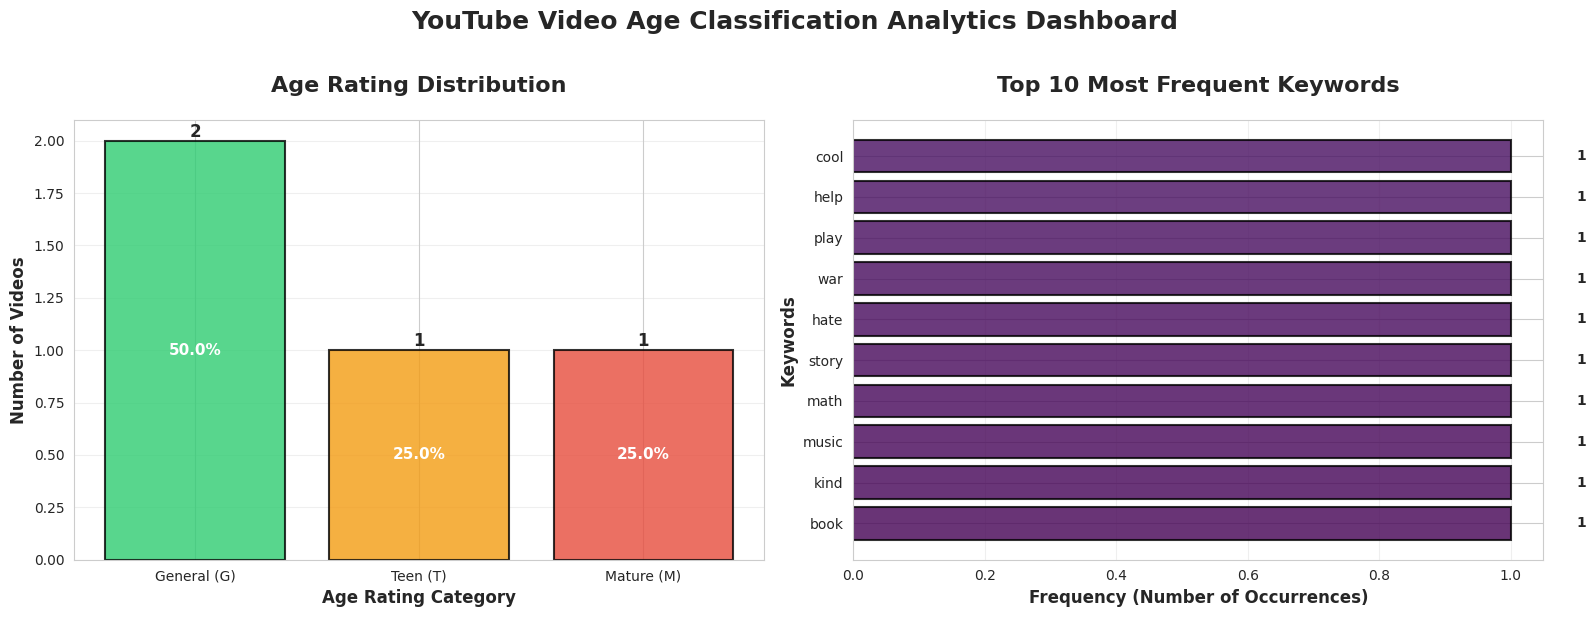

ANALYTICS SUMMARY

📊 Total Videos Analyzed: 4

🎯 Age Rating Distribution:
   General (G): 2 videos (50.0%)
   Teen (T): 1 videos (25.0%)
   Mature (M): 1 videos (25.0%)

🔤 Keyword Statistics:
   Total Keywords Found: 10
   Unique Keywords: 10
   Top 3 Keywords:
      - 'cool': 1 occurrences
      - 'help': 1 occurrences
      - 'play': 1 occurrences

📈 Average Keyword Scores per Video:
   General (G): 15.0
   Teen (T): 4.5
   Mature (M): 1.2

🏆 Most Viewed Video by Category:
   General (G): 'MARINA AND THE DIAMONDS - PRIMADONNA [Official Mus...' (143,752,507 views)
   Teen (T): 'Me at the zoo' (381,462,986 views)
   Mature (M): '$456,000 Squid Game In Real Life!' (905,040,162 views)


DETAILED RESULTS TABLE
                                                                                    Title  Age Rating                   Top Keywords  View Count
                                                                            Me at the zoo    Teen (T)                           cool   381

In [ ]:
# Cell 9: Analytics Dashboard

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set style for better-looking charts
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 10


def load_classified_data(filepath):
    """
    Load the classified data from JSON file.

    Args:
        filepath: Path to the classified_data.json file

    Returns:
        List of video data dictionaries
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✓ Successfully loaded {len(data)} videos from {filepath}\n")
        return data
    except FileNotFoundError:
        print(f"❌ Error: File not found at {filepath}")
        return None
    except json.JSONDecodeError:
        print(f"❌ Error: Invalid JSON format in {filepath}")
        return None
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None


def prepare_dataframe(videos_data):
    """
    Convert classified video data into a Pandas DataFrame.

    Args:
        videos_data: List of video dictionaries

    Returns:
        DataFrame with relevant columns
    """
    records = []

    for video in videos_data:
        # Extract metadata
        title = video.get('metadata', {}).get('title', 'Unknown')
        channel = video.get('metadata', {}).get('channel', 'Unknown')
        view_count = video.get('metadata', {}).get('view_count', 0)

        # Extract classification data
        classification = video.get('age_classification', {})
        rating = classification.get('predicted_rating', 'General (G)')
        top_keywords = classification.get('top_keywords', 'None')
        scores = classification.get('scores', {})

        record = {
            'Title': title,
            'Channel': channel,
            'View Count': view_count,
            'Age Rating': rating,
            'Top Keywords': top_keywords,
            'G Score': scores.get('General', 0),
            'T Score': scores.get('Teen', 0),
            'M Score': scores.get('Mature', 0)
        }
        records.append(record)

    df = pd.DataFrame(records)
    print(f"✓ Created DataFrame with {len(df)} rows and {len(df.columns)} columns\n")
    return df


def create_age_distribution_chart(df, ax):
    """
    Create a bar chart showing the distribution of age ratings.

    Args:
        df: DataFrame with age ratings
        ax: Matplotlib axis object
    """
    # Count videos in each category
    rating_counts = df['Age Rating'].value_counts()

    # Define colors for each rating
    color_map = {
        'General (G)': '#2ecc71',  # Green
        'Teen (T)': '#f39c12',     # Orange
        'Mature (M)': '#e74c3c'    # Red
    }

    # Ensure all categories are present (even if count is 0)
    categories = ['General (G)', 'Teen (T)', 'Mature (M)']
    counts = [rating_counts.get(cat, 0) for cat in categories]
    colors = [color_map[cat] for cat in categories]

    # Create bar chart
    bars = ax.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Styling
    ax.set_title('Age Rating Distribution', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Age Rating Category', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Videos', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add percentage labels
    total = sum(counts)
    for i, (cat, count) in enumerate(zip(categories, counts)):
        if total > 0:
            percentage = (count / total) * 100
            ax.text(i, count/2, f'{percentage:.1f}%',
                   ha='center', va='center', fontsize=11, fontweight='bold', color='white')


def create_keyword_frequency_chart(df, ax):
    """
    Create a horizontal bar chart showing the top 10 most frequent keywords.

    Args:
        df: DataFrame with top keywords
        ax: Matplotlib axis object
    """
    # Extract all keywords from all videos
    all_keywords = []

    for keywords_str in df['Top Keywords']:
        if keywords_str and keywords_str != 'None detected' and keywords_str != 'None':
            # Split by comma and clean
            keywords = [k.strip().lower() for k in str(keywords_str).split(',')]
            all_keywords.extend(keywords)

    # Count keyword frequencies
    if all_keywords:
        keyword_counts = Counter(all_keywords)
        top_10 = keyword_counts.most_common(10)

        keywords = [item[0] for item in top_10]
        counts = [item[1] for item in top_10]

        # Create color gradient (from light to dark)
        colors = plt.cm.viridis(range(len(keywords)))[::-1]  # Reverse for dark at top

        # Create horizontal bar chart
        bars = ax.barh(keywords, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

        # Add value labels
        for i, (bar, count) in enumerate(zip(bars, counts)):
            ax.text(count + 0.1, i, f'{count}',
                   va='center', fontweight='bold', fontsize=10)

        # Styling
        ax.set_title('Top 10 Most Frequent Keywords', fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Frequency (Number of Occurrences)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Keywords', fontsize=12, fontweight='bold')
        ax.invert_yaxis()  # Highest at top
        ax.grid(axis='x', alpha=0.3)

    else:
        # No keywords found
        ax.text(0.5, 0.5, 'No keywords detected in videos',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.set_title('Top 10 Most Frequent Keywords', fontsize=16, fontweight='bold', pad=20)
        ax.axis('off')


def generate_summary_statistics(df):
    """
    Generate and print summary statistics.

    Args:
        df: DataFrame with video data
    """
    print("=" * 70)
    print("ANALYTICS SUMMARY")
    print("=" * 70)

    # Basic stats
    total_videos = len(df)
    print(f"\n📊 Total Videos Analyzed: {total_videos}")

    # Rating distribution
    print(f"\n🎯 Age Rating Distribution:")
    rating_counts = df['Age Rating'].value_counts()
    for rating in ['General (G)', 'Teen (T)', 'Mature (M)']:
        count = rating_counts.get(rating, 0)
        percentage = (count / total_videos * 100) if total_videos > 0 else 0
        print(f"   {rating}: {count} videos ({percentage:.1f}%)")

    # Keyword stats
    all_keywords = []
    for keywords_str in df['Top Keywords']:
        if keywords_str and keywords_str != 'None detected' and keywords_str != 'None':
            keywords = [k.strip() for k in str(keywords_str).split(',')]
            all_keywords.extend(keywords)

    unique_keywords = len(set(all_keywords))
    total_keywords = len(all_keywords)

    print(f"\n🔤 Keyword Statistics:")
    print(f"   Total Keywords Found: {total_keywords}")
    print(f"   Unique Keywords: {unique_keywords}")

    if all_keywords:
        keyword_counts = Counter(all_keywords)
        most_common = keyword_counts.most_common(3)
        print(f"   Top 3 Keywords:")
        for keyword, count in most_common:
            print(f"      - '{keyword}': {count} occurrences")

    # Average scores
    print(f"\n📈 Average Keyword Scores per Video:")
    print(f"   General (G): {df['G Score'].mean():.1f}")
    print(f"   Teen (T): {df['T Score'].mean():.1f}")
    print(f"   Mature (M): {df['M Score'].mean():.1f}")

    # Most viewed video in each category
    print(f"\n🏆 Most Viewed Video by Category:")
    for rating in ['General (G)', 'Teen (T)', 'Mature (M)']:
        category_df = df[df['Age Rating'] == rating]
        if not category_df.empty:
            top_video = category_df.loc[category_df['View Count'].idxmax()]
            views = top_video['View Count']
            title = top_video['Title'][:50] + "..." if len(top_video['Title']) > 50 else top_video['Title']
            print(f"   {rating}: '{title}' ({views:,} views)")
        else:
            print(f"   {rating}: No videos")

    print("\n" + "=" * 70 + "\n")


# Main Execution
if __name__ == "__main__":
    print("\n" + "=" * 70)
    print("ANALYTICS DASHBOARD - Age Classification Results")
    print("=" * 70 + "\n")

    # File path
    data_path = "/content/drive/My Drive/AI_Project_2026/classified_data.json"

    # Load data
    videos_data = load_classified_data(data_path)

    if videos_data is None:
        print("❌ Cannot proceed without data. Please check the file path.")
    else:
        # Convert to DataFrame
        df = prepare_dataframe(videos_data)

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('YouTube Video Age Classification Analytics Dashboard',
                     fontsize=18, fontweight='bold', y=1.02)

        # Chart 1: Age Distribution
        create_age_distribution_chart(df, ax1)

        # Chart 2: Keyword Frequency
        create_keyword_frequency_chart(df, ax2)

        # Adjust layout
        plt.tight_layout()

        # Save the dashboard
        output_path = "/content/drive/My Drive/AI_Project_2026/dashboard_results.png"
        try:
            plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"✓ Dashboard saved to: {output_path}\n")
        except Exception as e:
            print(f"⚠️  Could not save to Drive: {e}")
            print("Saving to local directory instead...")
            plt.savefig("dashboard_results.png", dpi=300, bbox_inches='tight', facecolor='white')
            print("✓ Dashboard saved to: dashboard_results.png\n")

        # Display the charts
        plt.show()

        # Generate summary statistics
        generate_summary_statistics(df)

        # Optional: Display the DataFrame
        print("=" * 70)
        print("DETAILED RESULTS TABLE")
        print("=" * 70)
        print(df[['Title', 'Age Rating', 'Top Keywords', 'View Count']].to_string(index=False))
        print("\n" + "=" * 70)
        print("✅ ANALYTICS DASHBOARD COMPLETE")
        print("=" * 70)

In [ ]:
# Cell 8: Run Experiment 02 (Real Data Ingestion Test)
# Purpose: Scrapes 3 real videos to verify API connectivity.
#          Then, it runs your Age Classifier on this FRESH data.

import sys
import pandas as pd
sys.path.append("/content/drive/My Drive/AI_Project_2026")

from data_ingestion import YouTubeScraper
from age_analysis_engine.processor import AgeClassifier

# 1. Define 3 Real URLs (Diverse Types)
test_urls = [
    "https://www.youtube.com/watch?v=jNQXAC9IVRw", # "Me at the zoo" (The first YT video ever - Very Safe)
    "https://www.youtube.com/watch?v=CqJc4r8eDmw",  # A video that is no longer available. Added to show that the program does`nt crash  in such scenrios
    "https://www.youtube.com/watch?v=HZ7PAyCDwEg"  # Fast and Furios: Hobbs & Shaw trailer
    # You can add a 3rd URL here if you want to test a specific case!
]

# 2. Run Scraper
scraper = YouTubeScraper()
real_df = scraper.process_url_list(test_urls)

if not real_df.empty:
    print("\n✅ SCRAPING SUCCESS!")
    print(f"Collected {len(real_df)} videos.")

    # 3. Run Your Age Model on this Real Data
    classifier = AgeClassifier()
    analyzed_real_df = classifier.process_batch(real_df)

    # 4. Show Results
    display(analyzed_real_df[['title', 'age_label_name', 'justification_keywords']])

    # 5. Save this to replace our Mock Data?
    # analyzed_real_df.to_parquet("/content/drive/My Drive/AI_Project_2026/data/raw_dataset.parquet")
    # print("Saved to storage.")
else:
    print("❌ Scraping failed. Check dependencies.")

🚀 Starting Scraping for 3 videos...
   ...Processing: https://www.youtube.com/watch?v=jNQXAC9IVRw
      ✅ Success: Me at the zoo...
   ...Processing: https://www.youtube.com/watch?v=CqJc4r8eDmw


ERROR: [youtube] CqJc4r8eDmw: Video unavailable


⚠️ Metadata Error for CqJc4r8eDmw: ERROR: [youtube] CqJc4r8eDmw: Video unavailable
⚠️ No Transcript found for CqJc4r8eDmw: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=CqJc4r8eDmw! This is most likely caused by:

The video is no longer available

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!
   ...Processing: https://www.youtube.com/watch?v=HZ7PAyCDwEg
      ✅ Success: Fast & Furious Presents: Hobbs...

✅ SCRAPING SUCCESS!
Collected 2 videos.


,title,age_label_name,justification_keywords
0,Me at the zoo,General Audience (G),[]
1,Fast & Furious Presents: Hobbs & Shaw - Offici...,General Audience (G),[]


In [ ]:
# Cell 9 (Final Retry): Generate Dataset
import pandas as pd
import importlib
import data_ingestion
importlib.reload(data_ingestion) # Force load the fix
from data_ingestion import YouTubeScraper

print("✅ Module Reloaded. Starting Scrape...")

target_urls = [
    "https://www.youtube.com/watch?v=jNQXAC9IVRw", # Me at the zoo
    "https://www.youtube.com/watch?v=0e3GPea1Tyg", # MrBeast
    "https://www.youtube.com/watch?v=jLOuMXnM5wk", # TED-Ed
    "https://www.youtube.com/watch?v=LIEiEwpEhWM", # Physics Wallah
    "https://www.youtube.com/watch?v=QleVkPhz5Dk"  # Coke Studio
]

scraper = YouTubeScraper()
df = scraper.process_url_list(target_urls)

if not df.empty:
    output_path = "/content/drive/My Drive/AI_Project_2026/data/raw_dataset.parquet"
    df.to_parquet(output_path, index=False)
    print("\n✅ DATASET COMPLETE! All 5 videos secured.")
    print(f"   - Saved to: {output_path}")
    display(df[['title', 'publish_date']])

✅ Module Reloaded. Starting Scrape...
🚀 Starting Scraping for 5 videos...
   ...Processing: https://www.youtube.com/watch?v=jNQXAC9IVRw
      ✅ Success: Me at the zoo...
   ...Processing: https://www.youtube.com/watch?v=0e3GPea1Tyg
      ✅ Success: $456,000 Squid Game In Real Li...
   ...Processing: https://www.youtube.com/watch?v=jLOuMXnM5wk
      ✅ Success: The best way to become good at...
   ...Processing: https://www.youtube.com/watch?v=LIEiEwpEhWM
      ℹ️ No direct English. Checking 1 other options...
⚠️ Transcript skipped for LIEiEwpEhWM: No translatable transcripts found.
   ...Processing: https://www.youtube.com/watch?v=QleVkPhz5Dk
      ✅ Success: Sing Emotional English x Punja...

✅ DATASET COMPLETE! All 5 videos secured.
   - Saved to: /content/drive/My Drive/AI_Project_2026/data/raw_dataset.parquet


,title,publish_date
0,Me at the zoo,20050424
1,"$456,000 Squid Game In Real Life!",20211124
2,The best way to become good at something might...,20251104
3,Sing Emotional English x Punjabi Mashup Songs ...,20260116
